# CatBoost scorecards

Upcoming addition to [**`xbooster`**](https://github.com/xRiskLab/xBooster) package.

Author: https://www.github.com/deburky

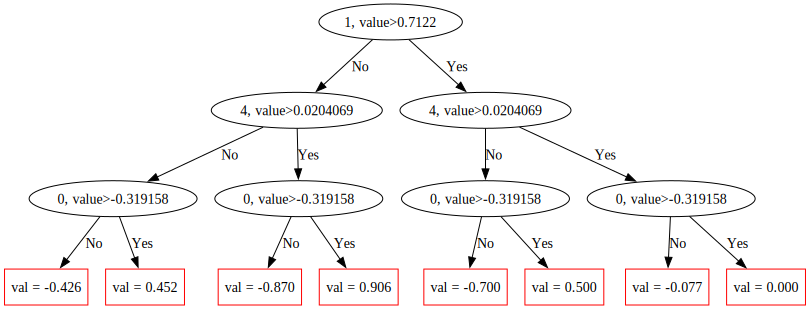

In [5]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification

# Step 1: Fit a CatBoost model
X, y = make_classification(n_samples=1000, n_features=5, random_state=42)
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
model = CatBoostClassifier(iterations=10, depth=3, verbose=0)
model.fit(X, y)
model.plot_tree(tree_idx=0)  # .render(filename='cb_tree', format='png')

In [6]:
import catboost as cb

# get available methods from cb_obj
cb_obj = model._object
tree_count = cb_obj._get_tree_count()
tree_leaf_count = cb_obj._get_tree_leaf_counts()
cb_depth = model.get_all_params()["depth"]
print(f"Tree count: {tree_count}")
print(f"Tree leaf count: {tree_leaf_count}")
print(f"Tree depth: {2**cb_depth}")

# Tree splits
pool = cb.Pool(X, y)
cb_obj._get_tree_splits(0, pool)

Tree count: 10
Tree leaf count: [8 8 8 8 8 8 8 8 8 8]
Tree depth: 8


['feature_0, bin=-0.319158',
 'feature_4, bin=0.0204069',
 'feature_1, bin=0.7122']

## Scorecard from splits

In [7]:
from catboost import CatBoostClassifier, Pool
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression

from catboost_scorecard import CatBoostScorecard

# Prepare data
X, y = make_classification(
    n_samples=1000, n_features=5, random_state=42, weights=[0.9, 0.1]
)
pool = Pool(X, y)

# Fit model
model = CatBoostClassifier(iterations=10, depth=1, verbose=0, learning_rate=1.0)
model.fit(pool)

# Run scorecard extraction
scorecard = CatBoostScorecard.trees_to_scorecard(model, pool)

tree_idx = 5
print(len(scorecard.query("Tree == @tree_idx")))
display(scorecard.query("Tree == @tree_idx"))

df = scorecard.query("Tree == @tree_idx").copy()
df["avg"] = y.mean()
df["diff"] = df["avg"] - df["EventRate"]
correlation_event_rate = df[["LeafValue", "diff"]].corr(method="spearman").values[0, 1]
print(f"Spearman correlation (EventRate): {correlation_event_rate:.4f}")
df[["LeafValue", "diff", "EventRate"]]

correlation_woe = df[["LeafValue", "WOE"]].corr(method="spearman").values[0, 1]
print(f"Spearman correlation (WOE): {correlation_woe:.4f}")

x, target = df[["WOE"]], df["LeafValue"]
lr_model = LinearRegression()
lr_model.fit(x, target)
print(f"Intercept: {lr_model.intercept_:.4f}")
print(f"Coefficient: {lr_model.coef_[0]:.4f}")

r2 = lr_model.score(x, target)
print(f"R^2: {r2:.4f}")

2


,Tree,LeafIndex,Conditions,Count,NonEvents,Events,EventRate,LeafValue,WOE
10,5,0,4 <= -1.91207,15,2,13,0.866667,0.638,4.014666
11,5,1,4 > -1.91207,985,893,92,0.093401,-0.029,-0.129935


Spearman correlation (EventRate): -1.0000
Spearman correlation (WOE): 1.0000
Intercept: -0.0081
Coefficient: 0.1609
R^2: 1.0000


,Tree,LeafIndex,Conditions,Count,NonEvents,Events,EventRate,LeafValue,WOE
10,5,0,4 <= -1.91207,15,2,13,0.866667,0.638,4.014666
11,5,1,4 > -1.91207,985,893,92,0.093401,-0.029,-0.129935


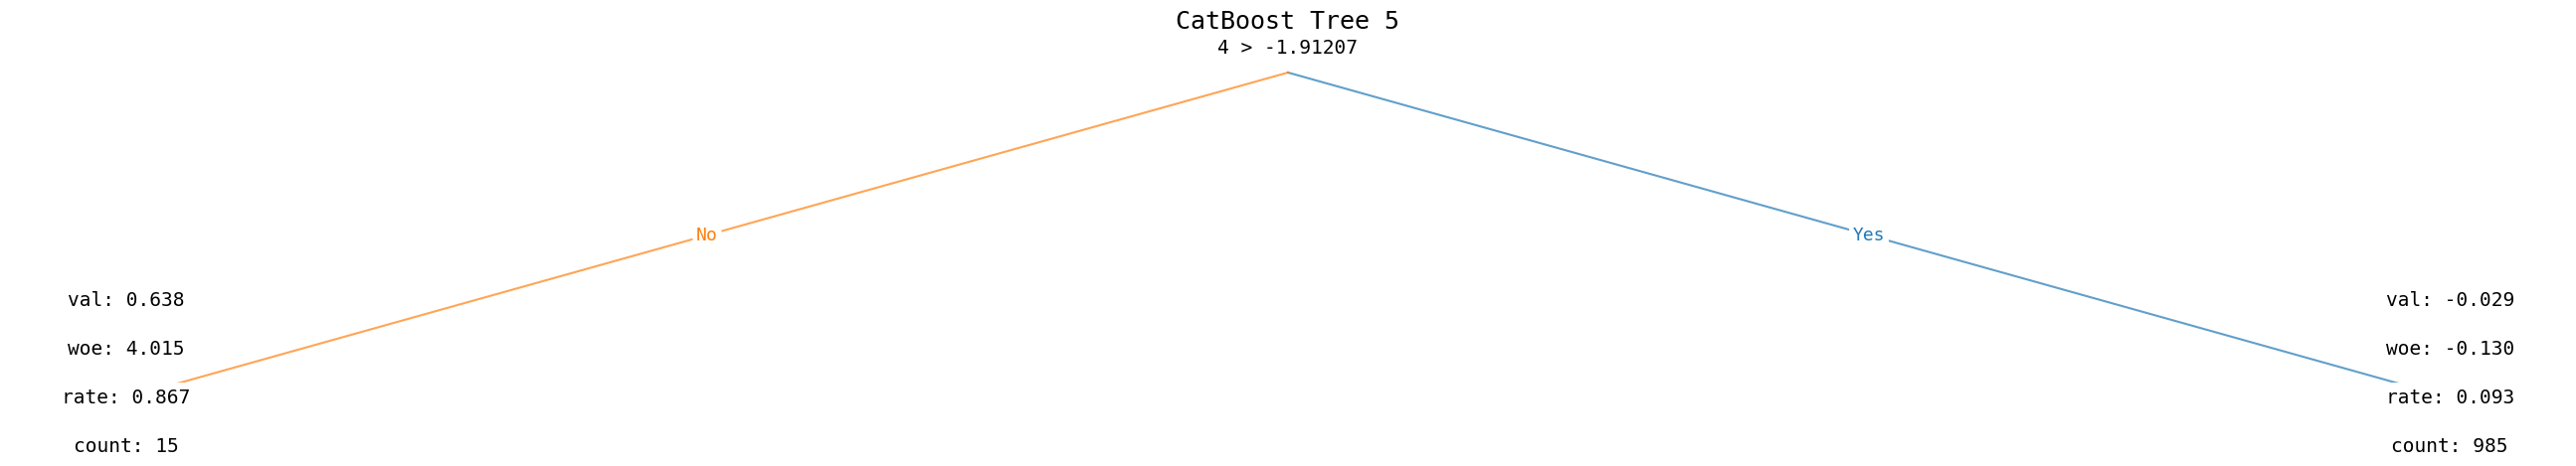

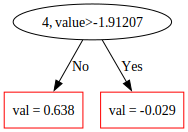

In [8]:
from utils import CatBoostTreeVisualizer

display(scorecard.query("Tree == @tree_idx"))
visualizer = CatBoostTreeVisualizer(scorecard)
visualizer.plot_tree(tree_idx=tree_idx)
model.plot_tree(tree_idx=tree_idx)

## Categorical features
Focus on clean, interpretable split rules

### High-cardinality categorical data

Unique values after preprocessing: 3934
Contains '__other__': True
Time taken: 0.01 seconds
Tree 0 has 8 leaves


,Tree,LeafIndex,Conditions,Count,NonEvents,Events,EventRate,LeafValue,WOE
0,0,0,high_card_cat != 'cat_1808' AND high_card_cat != 'cat_13899' AND high_card_cat != 'cat_18810',4996.0,2559.0,2437.0,0.48779,-0.005,0.001562
1,0,1,high_card_cat != 'cat_1808' AND high_card_cat != 'cat_13899' AND high_card_cat = 'cat_18810',2.0,2.0,0.0,0.00000,-0.029,-6.856344
2,0,2,high_card_cat != 'cat_1808' AND high_card_cat = 'cat_13899' AND high_card_cat != 'cat_18810',1.0,1.0,0.0,0.00000,-0.015,-6.856344
3,0,3,high_card_cat != 'cat_1808' AND high_card_cat = 'cat_13899' AND high_card_cat = 'cat_18810',0.0,0.0,0.0,0.48740,0.000,0.000000
4,0,4,high_card_cat = 'cat_1808' AND high_card_cat != 'cat_13899' AND high_card_cat != 'cat_18810',1.0,1.0,0.0,0.00000,-0.015,-6.856344


17.1 kB


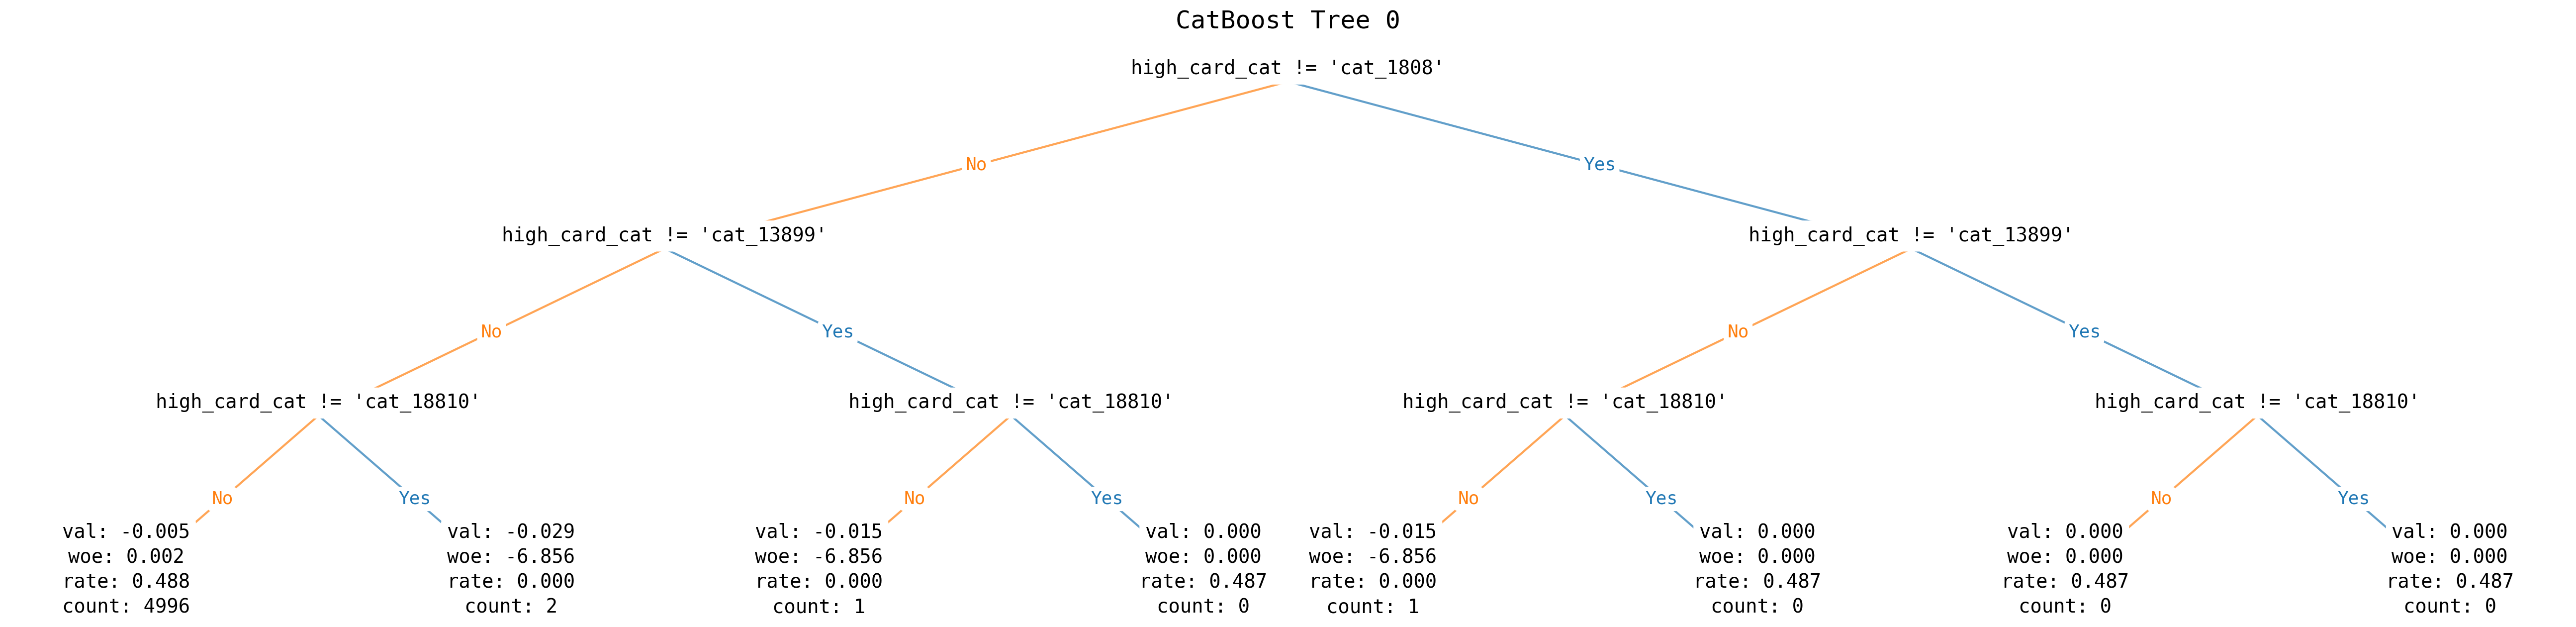

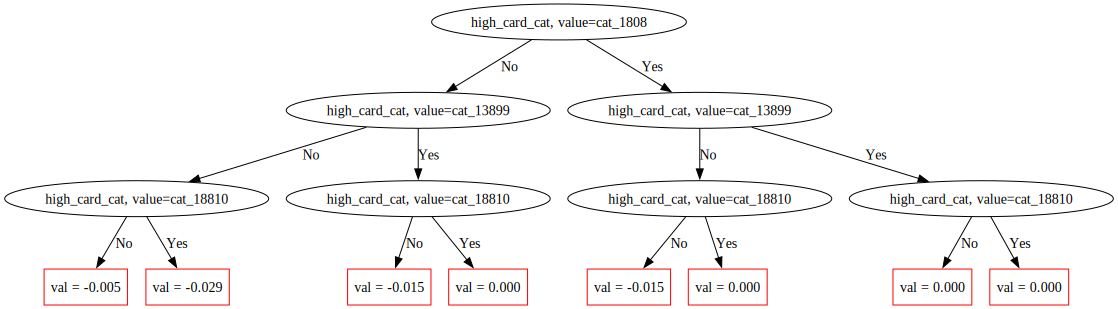

In [1]:
import time

import numpy as np
import humanize
import catboost as cb
import pandas as pd
from utils import CatBoostPreprocessor
from catboost_scorecard import CatBoostScorecard
from utils import CatBoostTreeVisualizer

pd.set_option("display.max_colwidth", 100)

# High cardinal data
n_samples = 5_000
n_categories = 20_000

# Generate synthetic data
df = pd.DataFrame(
    {
        "high_card_cat": np.random.choice(
            [f"cat_{i}" for i in range(n_categories)], size=n_samples
        ),
        "target": np.random.randint(0, 2, size=n_samples),
    }
)

cat_feature = "high_card_cat"

# Apply the preprocessor (reduce to top 50 categories)
preproc = CatBoostPreprocessor()
df_processed = preproc.fit_transform(df, cat_features=[cat_feature])

# Confirm preprocessing worked
print(f"Unique values after preprocessing: {df_processed[cat_feature].nunique()}")
print(f"Contains '__other__': {'__other__' in df_processed[cat_feature].unique()}")

# Train CatBoost
pool = cb.Pool(
    data=df_processed[[cat_feature]],
    label=df_processed["target"],
    cat_features=[cat_feature],
)

model = cb.CatBoostClassifier(
    iterations=10,
    allow_writing_files=False,
    depth=3,
    learning_rate=0.1,
    verbose=0,
    one_hot_max_size=9999,
    cat_features=[cat_feature],
)
model.fit(pool)

# Extract scorecard
output_format = "pandas"

time_start = time.time()
scorecard = CatBoostScorecard.trees_to_scorecard(
    model, pool, output_format=output_format
)
time_end = time.time()
print(f"Time taken: {time_end - time_start:.2f} seconds")

# # Show a tree's scorecard
tree_idx = 0
if output_format == "arrow":
    scorecard = scorecard.to_pandas()
print(f"Tree {tree_idx} has {len(scorecard.query('Tree == @tree_idx'))} leaves")
display(scorecard.query("Tree == @tree_idx").head())

try:
    print(humanize.naturalsize(scorecard.nbytes))
except AttributeError:
    size_bytes = scorecard.memory_usage(deep=True).sum()
    print(humanize.naturalsize(size_bytes))


visualizer = CatBoostTreeVisualizer(scorecard)
visualizer.plot_tree(tree_idx=tree_idx)

model.plot_tree(
    tree_idx=tree_idx,
    pool=pool,
)

In [2]:
from catboost_woe_mapper import CatBoostWOEMapper

# Create WOE and LeafValue mappers
woe_mapper = CatBoostWOEMapper(scorecard, use_woe=True)
leaf_mapper = CatBoostWOEMapper(scorecard, use_woe=False)  # Uses LeafValue

test_data = df_processed[[cat_feature]]

# Or get raw scores
woe_scores = woe_mapper.predict_score(test_data)
leaf_scores = leaf_mapper.predict_score(test_data)

In [3]:
from sklearn.metrics import roc_auc_score

# CatBoost
preds = model.predict_proba(df_processed[[cat_feature]])[:, 1]
gini = 2 * roc_auc_score(df_processed["target"], preds) - 1
print(f"CB Gini: {gini:.4f}")

# WOE
preds = pd.Series(woe_scores)
gini = 2 * roc_auc_score(df_processed["target"], preds) - 1
print(f"WOE Gini: {gini:.4f}")

# Leaves
preds = pd.Series(leaf_scores)
gini = 2 * roc_auc_score(df_processed["target"], preds) - 1
print(f"WOE Gini: {gini:.4f}")

CB Gini: 0.0271
WOE Gini: 0.0271
WOE Gini: 0.0271


In [4]:
np.corrcoef(woe_scores, leaf_scores)[0, 1]  # Correlation

1.0

In [5]:
leaf_scores

array([-0.037, -0.037, -0.037, ..., -0.001, -0.001, -0.001])

In [6]:
cb_raw = model.predict(
    df_processed[[cat_feature]],
    prediction_type="RawFormulaVal",
).round(3)

print(f"CatBoost raw scores:\n{cb_raw[:10]}")
np.corrcoef(cb_raw, leaf_scores)[0, 1]  # Correlation

CatBoost raw scores:
[-0.036 -0.036 -0.036 -0.036 -0.036 -0.036 -0.036 -0.036 -0.036 -0.036]


0.9999766140208147

In [7]:
# Create the mapper
mapper = CatBoostWOEMapper(scorecard)

# Create the enhanced scorecard with points
enhanced_scorecard = mapper.create_scorecard(
    pdo_params={
        "pdo": 50,
        "target_points": 600,
        "target_odds": 19,
        "precision_points": 0,
    }
)

# Predict using different methods
raw_scores = mapper.predict_score(test_data, method="raw")
woe_scores = mapper.predict_score(test_data, method="woe")
points_scores = mapper.predict_score(test_data, method="pdo")

### Credit data

In [1]:
import pandas as pd
import catboost as cb
import time

from catboost_scorecard import CatBoostScorecard
from catboost_woe_mapper import CatBoostWOEMapper

credit_data = pd.read_csv("../data/BankCaseStudyData.csv")
num_features = ["Gross_Annual_Income"]
categorical_features = ["Time_with_Bank"]
features = num_features + categorical_features

X = credit_data[features]
y = credit_data["Final_Decision"].replace({"Accept": 1, "Decline": 0})

pool = cb.Pool(
    data=X,
    label=y,
    cat_features=categorical_features,
)

model = cb.CatBoostClassifier(
    iterations=100,
    allow_writing_files=False,
    depth=1,
    learning_rate=0.1,
    verbose=0,
    one_hot_max_size=9999,
    cat_features=categorical_features,
)
model.fit(pool)

# Extract scorecard
output_format = "pandas"
time_start = time.time()
scorecard = CatBoostScorecard.trees_to_scorecard(
    model, pool, output_format=output_format
)
time_end = time.time()
print(f"Time taken: {time_end - time_start:.2f} seconds")

# Show a tree's scorecard
tree_idx = 0
if output_format == "arrow":
    scorecard = scorecard.to_pandas()
print(f"Tree {tree_idx} has {len(scorecard.query('Tree == @tree_idx'))} leaves")
display(scorecard.query("Tree == @tree_idx").head())

# Create the mapper
mapper = CatBoostWOEMapper(scorecard)

# Create the enhanced scorecard with points
enhanced_scorecard = mapper.create_scorecard(
    pdo_params={
        "pdo": 50,
        "target_points": 600,
        "target_odds": 19,
        "precision_points": 0,
    }
)

# Predict using different methods
raw_scores = mapper.predict_score(X, method="raw")
woe_scores = mapper.predict_score(X, method="woe")
points_scores = mapper.predict_score(X, method="pdo")

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_65043/1442888216.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = credit_data["Final_Decision"].replace({"Accept": 1, "Decline": 0})


Time taken: 0.13 seconds
Tree 0 has 2 leaves


,Tree,LeafIndex,Conditions,Count,NonEvents,Events,EventRate,LeafValue,WOE
0,0,0,Gross_Annual_Income <= 12006,12287,1954,10333,0.840970,0.136,-0.483060
1,0,1,Gross_Annual_Income > 12006,12572,643,11929,0.948855,0.179,0.772059


In [4]:
from sklearn.metrics import roc_auc_score

# CatBoost
preds = model.predict_proba(X[features])[:, 1]
gini = 2 * roc_auc_score(y, preds) - 1
print(f"CB Gini: {gini:.4f}")

# Leaves
preds = pd.Series(raw_scores)
gini = 2 * roc_auc_score(y, preds) - 1
print(f"Leaf Gini: {gini:.4f}")

# WOE
preds = pd.Series(woe_scores)
gini = 2 * roc_auc_score(y, preds) - 1
print(f"WOE Gini: {gini:.4f}")

# Points
preds = pd.Series(points_scores)
gini = 2 * roc_auc_score(y, preds) - 1
print(f"Points Gini: {gini:.4f}")

CB Gini: 0.6094
Leaf Gini: 0.6094
WOE Gini: 0.5867
Points Gini: 0.5706


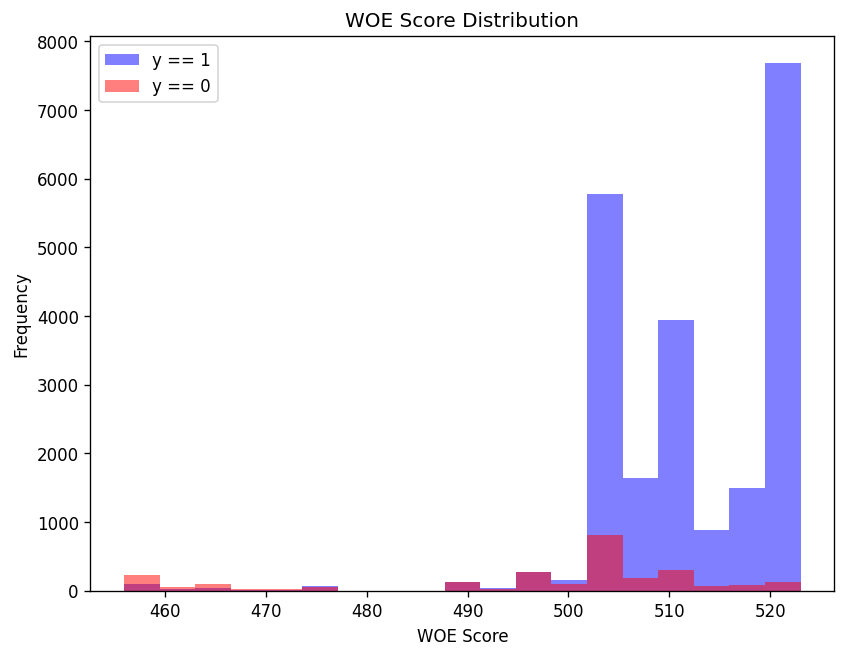

In [6]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(111)

score_min, score_max = points_scores.min(), points_scores.max()
# Create bins for the histogram
bins = np.linspace(score_min, score_max, 20)

# plot woe score hist based on y == 1
ax.hist(
    points_scores[y == 1],
    bins=bins,
    color="blue",
    alpha=0.5,
    label="y == 1",
)
# plot woe score hist based on y == 0
ax.hist(
    points_scores[y == 0],
    bins=bins,
    color="red",
    alpha=0.5,
    label="y == 0",
)
ax.set_xlabel("WOE Score")
ax.set_ylabel("Frequency")
ax.set_title("WOE Score Distribution")
ax.legend()
plt.show()

## Text features
### Not yet interpretable

In [13]:
import numpy as np
import catboost as cb
from faker import Faker
import pandas as pd
from catboost_scorecard import CatBoostScorecard

fake_text = Faker()

X_df = pd.DataFrame(
    {
        "numerical_1": np.random.randn(1000),
        "numerical_2": np.random.randn(1000),
        "product_type": np.random.choice(["book", "movie", "music"], size=1000),
        "country": np.random.choice(["US", "UK", "JP"], size=1000),
        "description": [fake_text.text() * 100 for _ in range(1000)],
    }
)

y = np.random.randint(0, 2, size=1000)

# Define categorical features (including text)
cat_features = ["product_type", "country", "description"]

# Create Pool and train model
pool = cb.Pool(X_df, y, cat_features=cat_features, text_features=["description"])
model = cb.CatBoostClassifier(iterations=10, depth=3, verbose=0)
model.fit(pool)

# Generate scorecard
scorecard = CatBoostScorecard.trees_to_scorecard(model, pool)


# Show sample conditions
tree_idx = 0
display(scorecard.query("Tree == @tree_idx").head())

,Tree,LeafIndex,Conditions,Count,NonEvents,Events,EventRate,LeafValue,WOE
0,0,0,src_feature_id=0 calcer_id=578C767CE0D094152F21FE408253F66D local_id=11 <= 0.5 AND src_feature_i...,969.0,485.0,484.0,0.499484,-0.001,0.033940
1,0,1,src_feature_id=0 calcer_id=578C767CE0D094152F21FE408253F66D local_id=11 <= 0.5 AND src_feature_i...,13.0,11.0,2.0,0.153846,-0.360,-1.668744
2,0,2,src_feature_id=0 calcer_id=578C767CE0D094152F21FE408253F66D local_id=11 <= 0.5 AND src_feature_i...,6.0,2.0,4.0,0.666667,0.111,0.729151
3,0,3,src_feature_id=0 calcer_id=578C767CE0D094152F21FE408253F66D local_id=11 <= 0.5 AND src_feature_i...,0.0,0.0,0.0,0.491000,0.000,0.000000
4,0,4,src_feature_id=0 calcer_id=578C767CE0D094152F21FE408253F66D local_id=11 > 0.5 AND src_feature_id...,12.0,11.0,1.0,0.083333,-0.417,-2.361891


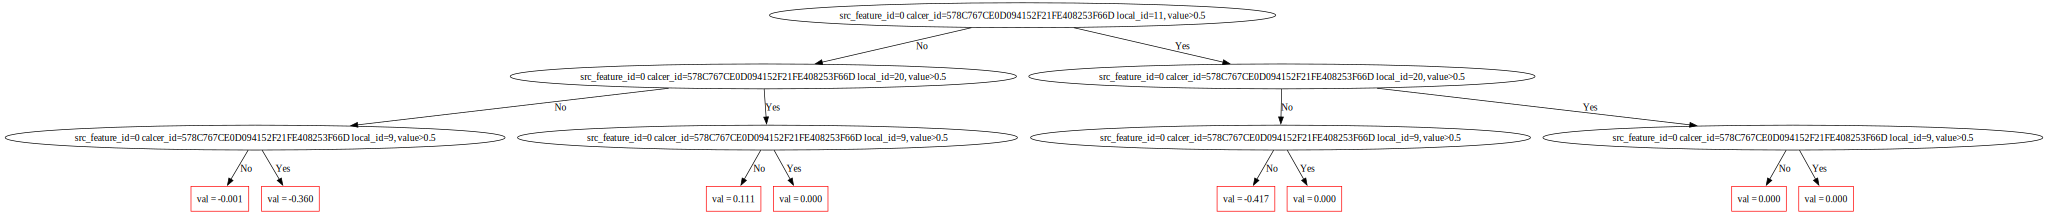

In [14]:
model.plot_tree(
    tree_idx=tree_idx,
    pool=pool,
)